In [91]:
from pycocotools.coco import COCO 
from PIL import Image 
import numpy as np 
import skimage.io as io 
import matplotlib.pyplot as plt 
import pylab 
import json 
import os 
import random 
import math 
import seaborn as sns 
from tqdm import tqdm 
import tensorflow as tf 
from tensorflow.keras.models import *
from tensorflow.keras.layers import * 
from tensorflow.keras.callbacks import *
from tensorflow.keras.preprocessing.text import * 
from tensorflow.keras.preprocessing.sequence import * 
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split
from sklearn.preprocessing import LabelBinarizer
import cv2 # apt-get install libgl1-mesa-glx

np.random.seed(2021) # for reproduceability 

# Data Preprocessing 

Preprocess the given data so that we have matching (Image, Question, Answer) triplets
Because the dataset is large, we will train using the VQA v2.0 validation dataset, and we will only use 50% of the data.  

In [2]:
with open('v2_mscoco_val2014_annotations.json') as json_file: 
    ans = json.load(json_file) 
    
with open('v2_OpenEnded_mscoco_val2014_questions.json') as json_file: 
    questions = json.load(json_file) 

In [3]:
image_dir = os.listdir('val2014/val2014/') 
len(image_dir) # total number of images 

40504

In [4]:
# let's use half of the given images  
index = np.random.choice(len(image_dir), int(0.5 * len(image_dir)), replace = False) 

In [5]:
image_dir = np.asarray(image_dir) 
image_dir = image_dir[index] 
image_dir.shape

(20252,)

In [6]:
# get ids for each of the selected images 
image_ids = [] 
for i in range(len(image_dir)): 
    int_id = int(image_dir[i][14:25]) 
    image_ids.append(int_id) 
    
image_ids = np.asarray(image_ids) 
image_ids

array([447038, 262360, 251717, ...,  11122, 290896, 271576])

In [9]:
arr1 = [] # contains (image_id, question_id, question)
question_ids = [] 
for i in tqdm(range(len(questions['questions'])), position = 0, leave = True): 
    if questions['questions'][i]['image_id'] in image_ids: 
        arr1.append((questions['questions'][i]['image_id'],
                     questions['questions'][i]['question_id'], 
                     questions['questions'][i]['question']))      
        question_ids.append(questions['questions'][i]['question_id'])

100%|██████████| 214354/214354 [00:03<00:00, 61073.71it/s]


In [10]:
arr2 = [] # contains (question_id, answer) 

for i in tqdm(range(len(ans['annotations'])), position = 0, leave = True): 
    if ans['annotations'][i]['question_id'] in question_ids:   
        arr2.append((ans['annotations'][i]['question_id'], 
                     ans['annotations'][i]['multiple_choice_answer']))


100%|██████████| 214354/214354 [03:01<00:00, 1182.03it/s]


In [11]:
print(len(arr1), len(arr2)) 

106733 106733


In [14]:
arr = [] # contains (image_id, question, answer) 

# merge information from arr1 and arr2 
for i in tqdm(range(len(arr2)), position = 0, leave = True): 
    for j in range(len(arr1)): 
        if arr2[i][0] == arr1[j][1]: # if the question ids match 
            arr.append((arr1[j][0], arr1[j][2], arr2[i][1])) # append (image_id, question, answer)
            

100%|██████████| 106733/106733 [29:24<00:00, 60.50it/s]


In [15]:
print("Total count for train dataset = {}".format(len(arr)))

Total count for train dataset = 106733


In [43]:
# get actual images for training from the triplet data 
X_images = [] 
X_questions = [] 
Y_answers = [] 

for i in tqdm(range(len(arr))): 
    image_id = arr[i][0] 
    question = arr[i][1] 
    answer = arr[i][2] 
    # obtain actual image from the image id 
    image_id_str = str(image_id) 
    while len(image_id_str) < 12: # prepend zero to make the length of the id 12 
        image_id_str = '0' + image_id_str  
    dirname = 'val2014/val2014/COCO_val2014_' + image_id_str + '.jpg' 
    image = Image.open(dirname).convert('RGB') 
    image = image.resize((224,224)) 
    image = np.asarray(image) 
    assert image.ndim == 3 
    X_images.append(image) 
    X_questions.append(question) 
    Y_answers.append(answer)
    


100%|██████████| 106733/106733 [15:14<00:00, 116.72it/s]


In [44]:
print("convert X_images to numpy array") 
X_images = np.asarray(X_images) 
print("convert X_questions to numpy array") 
X_questions = np.asarray(X_questions) 
print("convert Y_answers to numpy array") 
Y_answers = np.asarray(Y_answers) 

print("saving processed dataset...") 
np.save("small_X_images.npy", X_images) 
np.save("small_X_questions.npy", X_questions) 
np.save("small_Y_answers.npy", Y_answers) 

convert X_images to numpy array
convert X_questions to numpy array
convert Y_answers to numpy array
saving processed dataset...


In [45]:
X_images.shape, X_questions.shape, Y_answers.shape

((106733, 224, 224, 3), (106733,), (106733,))

# Extracting Image Features

We need to convert images into fixed size vectors. VGG-19 is trained on the Imagenet dataset to classify the image into one of the answer classes. Because each image is scaled to 224x224, we will get a 7x7x512 dimensional vector representation for each image. 

In [51]:
# extract image features 
X_images_extracted = [] 

def VGG19_Top(): 
    model = tf.keras.applications.VGG19(include_top=False, weights = 'imagenet', input_shape = (224,224,3)) 
    input_layer = model.input
    hidden_layer = model.layers[-1].output 
    model = tf.keras.Model(input_layer, hidden_layer) 
    return model  

def generateImageFeatures(images): 
    model = VGG19_Top() 
    for i in tqdm(range(images.shape[0])):  
        features = model(images[i].reshape((1,224,224,3))) 
        X_images_extracted.append(features.numpy().reshape((7,7,512)))
        
        
generateImageFeatures(X_images)

100%|██████████| 106733/106733 [15:21<00:00, 115.85it/s]


In [52]:
X_images_extracted = np.asarray(X_images_extracted) 

X_images_extracted.shape 

(106733, 7, 7, 512)

# Creating Question Vectors

In [55]:
tokenizer_questions = tf.keras.preprocessing.text.Tokenizer(oov_token='<unk>', filters = '!"#$%&()*+.,-/:;=?@[\]^_`{|}~')

tokenizer_questions.fit_on_texts(X_questions)

train_question_seqs = tokenizer_questions.texts_to_sequences(X_questions) 

question_vector = tf.keras.preprocessing.sequence.pad_sequences(train_question_seqs, padding = 'post')

In [57]:
question_vector.shape

(106733, 23)

# Creating Answer Vectors

In [62]:
target_size = len(np.unique(Y_answers))
print("there are {} possible answers in our dataset".format(target_size))

there are 8926 possible answers in our dataset


In [92]:
label_encoder = LabelBinarizer() 
answer_vector = label_encoder.fit_transform(Y_answers)

In [95]:
answer_vector.shape

(106733, 8926)

# Save preprocessed data

In [88]:
np.save("image_features_small.npy", X_images_extracted)


# Train validation split

In [98]:
print("splitting images and questions...")
train_images, val_images, train_questions, val_questions = train_test_split(X_images_extracted, 
                                                                            question_vector, 
                                                                            test_size = 0.1, 
                                                                            random_state = 2021)
print("splitting answers and questions...")
train_answers, val_answers, _, _ = train_test_split(answer_vector,
                                                    question_vector,
                                                    test_size = 0.1,
                                                    random_state = 2021)

splitting images and questions...
splitting answers and questions...


In [99]:
print(train_images.shape, train_questions.shape, train_answers.shape) 

print(val_images.shape, val_questions.shape, val_answers.shape)

(96059, 7, 7, 512) (96059, 23) (96059, 8926)
(10674, 7, 7, 512) (10674, 23) (10674, 8926)


# Define and train model

In [100]:
def build_model(): 
    image_input = Input((7,7,512)) 
    question_input = Input((question_vector.shape[1],))
    
    # image pathway 
    image_conv_layer1 = Conv2D(filters = 4096, 
                               kernel_size = 7, 
                               strides = 1, 
                               padding = 'valid', 
                               activation = 'relu')(image_input)
    image_flatten = Flatten()(image_conv_layer1)
    image_dense1 = Dense(4096, activation = 'relu')(image_flatten) 
    image_dense2 = Dense(1024, activation = 'relu')(image_dense1) 
    
    # question pathway 
    question_embedding = Embedding(input_dim = len(tokenizer_questions.word_index)+1, output_dim = 300)(question_input)
    question_lstm = LSTM(1024, 
                         kernel_initializer = 'glorot_uniform', 
                         recurrent_initializer = 'orthogonal', 
                         bias_initializer = tf.keras.initializers.zeros())(question_embedding)
    question_flatten = Flatten()(question_lstm) 
    
    # pointwise multiplication 
    image_question = Multiply()([image_dense2, question_flatten]) 
    
    image_question_dense1 = Dense(1000, activation = 'relu')(image_question)
    image_question_dense2 = Dense(1000, activation = 'relu')(image_question_dense1) 
    
    outputs = Dense(target_size, activation = 'softmax')(image_question_dense2) 
    model = Model(inputs = [image_input, question_input], outputs = outputs)
    
    model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
    return model

In [101]:
model = build_model()
model.summary()

Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_17 (InputLayer)           [(None, 7, 7, 512)]  0                                            
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 1, 1, 4096)   102764544   input_17[0][0]                   
__________________________________________________________________________________________________
input_18 (InputLayer)           [(None, 23)]         0                                            
__________________________________________________________________________________________________
flatten_6 (Flatten)             (None, 4096)         0           conv2d_3[0][0]                   
____________________________________________________________________________________________

# Train Model

In [102]:
model_path = 'baseline_vqa_epoch_{epoch:03d}_val_{val_loss:.3f}_val_accuracy_{val_accuracy:.3f}.h5' 

learning_rate_reduction = ReduceLROnPlateau(monitor = 'val_loss', patience = 2, verbose = 1, factor = 0.8) 

checkpoint = ModelCheckpoint(filepath = model_path, monitor = 'val_loss', verbose = 1, save_best_only = True) 

early_stopping = EarlyStopping(monitor = 'val_loss', patience = 10)

history = model.fit([train_images, train_questions], 
                    train_answers, 
                    batch_size = 32, 
                    epochs = 50, 
                    validation_data = ([val_images, val_questions], val_answers), 
                    callbacks = [learning_rate_reduction, checkpoint, early_stopping]) 

Epoch 1/50
3002/3002 [==============================] - 235s 75ms/step - loss: 4.8627 - accuracy: 0.2093 - val_loss: 4.0121 - val_accuracy: 0.2369

Epoch 00001: val_loss improved from inf to 4.01206, saving model to baseline_vqa_epoch_001_val_4.012_val_accuracy_0.237.h5
Epoch 2/50
3002/3002 [==============================] - 187s 62ms/step - loss: 3.8636 - accuracy: 0.2424 - val_loss: 3.8944 - val_accuracy: 0.2520

Epoch 00002: val_loss improved from 4.01206 to 3.89435, saving model to baseline_vqa_epoch_002_val_3.894_val_accuracy_0.252.h5
Epoch 3/50
3002/3002 [==============================] - 220s 73ms/step - loss: 3.6161 - accuracy: 0.2530 - val_loss: 3.8050 - val_accuracy: 0.2529

Epoch 00003: val_loss improved from 3.89435 to 3.80502, saving model to baseline_vqa_epoch_003_val_3.805_val_accuracy_0.253.h5
Epoch 4/50
3002/3002 [==============================] - 183s 61ms/step - loss: 3.3641 - accuracy: 0.2681 - val_loss: 3.7742 - val_accuracy: 0.2694

Epoch 00004: val_loss improved 

# Plot loss and accuracy graph 

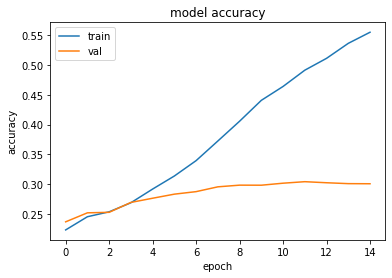

In [105]:
plt.plot(history.history['accuracy']) 
plt.plot(history.history['val_accuracy']) 
plt.title('model accuracy') 
plt.ylabel('accuracy') 
plt.xlabel('epoch')
plt.legend(['train','val'], loc='upper left') 
plt.show() 

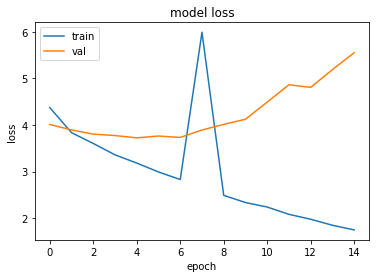

In [106]:
plt.plot(history.history['loss']) 
plt.plot(history.history['val_loss']) 
plt.title('model loss') 
plt.ylabel('loss') 
plt.xlabel('epoch')
plt.legend(['train','val'], loc='upper left') 
plt.show() 